<a href="https://colab.research.google.com/github/madara-tribe/ML_algorithms/blob/master/Pdcafield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from keras import optimizers
## Import usual libraries
import tensorflow as tf
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras import backend
from datetime import datetime #DB
import gc #DB
from tqdm import tqdm
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
warnings.filterwarnings("ignore")



import tensorflow as tf
import sys, time, warnings
import keras as keras
from keras.models import *
from keras.layers import *
#from keras.utils import plot_model #DB
warnings.filterwarnings("ignore")

#Function to add 2 convolutional layers with the parameters passed to it
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    #firt layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(x)
    x = BatchNormalization()(x)
    o = Activation('relu')(x)
    return o

PLUS=60
# like UNET_v1 but with a Conv2D layer betweeb UpSampling2D aand Concatenate layers
def UNET_v2( nClasses, input_height, input_width, n_filters=16*2, dropout=0.1):

    ## input_height and width must be devisible by 16 because maxpooling with filter size = (2,2) is operated 4 times,
    ## which makes the input_height and width 2^4 = 16 times smaller
    assert input_height%16 == 0
    assert input_width%16 == 0

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    ## Downscaling

    ## Block 1: 64, 64
    c1 = conv2d_block(img_input, n_filters * 1, kernel_size = 3)
    c1 = conv2d_block(c1, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1) # 112x112x64

    ## Block 2: 128, 128
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    c2 = conv2d_block(c2, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2) # 56x56x128

    ## Block 3: 256, 256
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    c3 = conv2d_block(c3, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3) # 28x28x256

    ## Block 4: 512, 512
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3)
    c4 = conv2d_block(c4, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4) # 14x14x512

    ## Block5: 1024, 1024
    c5 = conv2d_block(p4, n_filters = (n_filters * 16)+PLUS, kernel_size = 3)
    c5 = conv2d_block(c5, n_filters = (n_filters * 16)+PLUS, kernel_size = 3)
    p5 = Dropout(dropout)(c5) # 14x14x1024
    ## Upscaling

    ## Block6: 512, 512
    up6 = UpSampling2D(size=(2, 2), interpolation="bilinear")(p5) # 28x28x1024
    u6 = Conv2D(filters=n_filters*8, kernel_size=2, activation=None, padding="same", kernel_initializer="he_normal")(up6)
    m6 = Concatenate(axis=3)([u6, c4])
    m6 = BatchNormalization()(m6)
    c6 = conv2d_block(m6, n_filters * 8, kernel_size = 3)
    
    ## Block7: 256, 256
    up7 = UpSampling2D(size=(2, 2), interpolation="bilinear")(c6) #56x56x256
    u7 = Conv2D(filters=n_filters*4, kernel_size=2, activation=None, padding="same", kernel_initializer="he_normal")(up7)
    m7 = Concatenate(axis=3)([u7, c3])
    m7 = BatchNormalization()(m7)
    c7 = conv2d_block(m7, n_filters * 4, kernel_size = 3)
    
    ## Block8: 128, 128
    up8 = UpSampling2D(size=(2, 2), interpolation="bilinear")(c7) # 112x112x128
    u8  = Conv2D(filters=n_filters*2, kernel_size=2, activation=None, padding="same", kernel_initializer="he_normal")(up8)
    m8  = Concatenate(axis=3)([u8, c2])
    m8 = BatchNormalization()(m8)
    c8 = conv2d_block(m8, n_filters * 2, kernel_size = 3)
    
    ## Block9: 64, 64
    up9 = UpSampling2D(size=(2, 2), interpolation="bilinear")(c8) # 224x224x64
    u9  = Conv2D(filters=n_filters*1, kernel_size=2, activation=None, padding="same", kernel_initializer="he_normal")(up9)
    m9 = Concatenate(axis=3)([u9, c1])
    m9 = BatchNormalization()(m9)
    c9 = conv2d_block(m9, n_filters * 1, kernel_size = 3)
    
    ## Last layers
    c10 = Conv2D(filters=nClasses, kernel_size=1)(c9)
    o = (Activation("softmax"))(c10)
    model = Model(inputs=img_input, outputs=o)

    return model



N=160
HEIGHT = int(400-N)
WIDTH  = int(640-N)
print(HEIGHT, WIDTH)
N_CLASSES = 5

BATCH_SIZE = 2
EPOCHS = 100

weight_path='keras_model/fst.hdf5'
model_type = 2
model = UNET_v2(N_CLASSES, HEIGHT, WIDTH)
#model.load_weights(weight_path)
model.summary()


240 480
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 240, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 240, 480, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 240, 480, 32) 128         conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 240, 480, 32) 0           batch_normalization_128[0][0]    
_______________________________________________________________________________

2it [00:00, 14.32it/s]

train load


25it [00:01, 15.27it/s]
2it [00:00, 15.21it/s]

(25, 240, 480, 3) (25, 240, 480, 5)
1.0 0.0


10it [00:00, 14.81it/s]


(10, 240, 480, 3) (10, 240, 480, 5)
1.0 0.0


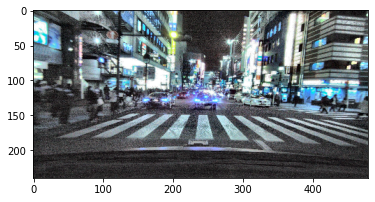

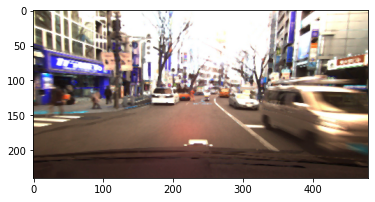

(<matplotlib.image.AxesImage at 0x7f65a86662b0>, None)

In [40]:


path='/content/drive/MyDrive/4cls/'
dir_train_img=path+'train'
dir_train_seg=path+'anno'
dir_valid_img = path+'val'
dir_valid_seg = path+'val_anno'

def noise_chale(bgr):
    ksize = 3
    #plt.imshow(bgr),plt.show()
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    #plt.imshow(lab),plt.show()
    lab_planes = cv2.split(lab)
    lab_planes[0] = cv2.medianBlur(lab_planes[0], ksize)
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
	


def flipud_image(X, Y):
    Xflip =np.array([img[::-1] for img in X])
    Yflip =np.array([img[::-1] for img in Y])
    return Xflip, Yflip
    
def fliplr_image(X, Y):
    Xflip =np.array([img[:, ::-1] for img in X])
    Yflip =np.array([img[:, ::-1] for img in Y])
    return Xflip, Yflip

def salt(img):
    row,col,ch = img.shape
    s_vs_p = 0.5
    amount = 0.004
    sp_img = img.copy()
    # pepper
    num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper)) for i in img.shape]
    sp_img[coords[:-1]] = (0,0,0)
    return sp_img
	
	
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    #img = img.astype(np.uint8)
    return img

def contrast(img, gamma = 0.5):
    gamma_cvt = np.zeros((256,1),dtype = 'uint8')
 
    for i in range(256):
        gamma_cvt[i][0] = 255 * (float(i)/255) ** (1.0/gamma)
    return cv2.LUT(img, gamma_cvt)

def sift_angle(image, y_move_ratio=0, x_move_ratio=0, angle_ratio=float(np.pi/60)):
    h, w, _ = np.shape(image)
    size = tuple(np.array([w, h]))
    print(size)
    #np.pi=3.141592653589793
    rad=angle_ratio
    move_x = x_move_ratio
    move_y = w * y_move_ratio

    matrix = [[np.cos(rad), -1 * np.sin(rad), move_x],
                   [np.sin(rad), np.cos(rad), move_y]]

    affine_matrix = np.float32(matrix)
    chage_angle = cv2.warpAffine(image, affine_matrix, size, flags=cv2.INTER_LINEAR)
    return chage_angle

def clahe(bgr):
    #plt.imshow(bgr),plt.show()
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    #plt.imshow(lab),plt.show()
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=10.0,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


def ContrastNormalizeImageArr(path, H, W, gamma=1.8):
    NORM_FACTOR = 255
    img = cv2.imread(path, 1)
    img = contrast(img, gamma = gamma)
    img = cv2.resize(img, (H, W), interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/NORM_FACTOR
    return img
def noise(img):
	ksize = 3
	for j in range(3):
		img[:,:,j]=cv2.medianBlur(img[:, :, j], ksize)
	return img


def NormalizeImageArr(path, H, W, aug_type=None):
    aug_type = aug_type
    NORM_FACTOR = 255
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (H, W), interpolation=cv2.INTER_NEAREST)
    if img.mean()<80:
        img = clahe(img)
    else: 
        img = noise_chale(img)
    
    if aug_type == 'pepper':
        img = salt(img)
    elif aug_type == 'sift':
        img = channel_shift(img, 60)
    else:
        pass
    img = img.astype(np.float32)
    img = img/NORM_FACTOR
    return img

def LoadSegmentationArr( path , nClasses,  width ,height):
    seg_labels = np.zeros((height, width, nClasses))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, : , 0]
    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    return seg_labels

print('train load')
train_images = os.listdir(dir_train_img)
train_images.sort()
train_segmentations  = os.listdir(dir_train_seg)
train_segmentations.sort()
X_train, Y_train=[], []

for im , seg in tqdm(zip(train_images[:25], train_segmentations[:25])):
    X_train.append(NormalizeImageArr(os.path.join(dir_train_img,im), WIDTH, HEIGHT, aug_type=None))
    Y_train.append(LoadSegmentationArr( os.path.join(dir_train_seg,seg), N_CLASSES, WIDTH, HEIGHT)  )

X_train, Y_train = np.array(X_train), np.array(Y_train)
#X1, Y1 = fliplr_image(X_train, Y_train)
#X_train = np.vstack([X_train, X1])

#X_train, Y_train = shuffle(X_train, Y_train)
print(X_train.shape,Y_train.shape)
print(X_train.max(), X_train.min())

# In[13]:


# load validation images
valid_images = os.listdir(dir_valid_img)
valid_images.sort()
valid_segmentations  = os.listdir(dir_valid_seg)
valid_segmentations.sort()
X_valid, Y_valid = [], []

for im , seg in tqdm(zip(valid_images,valid_segmentations)):
    X_valid.append(NormalizeImageArr(os.path.join(dir_valid_img,im), WIDTH, HEIGHT) )
    Y_valid.append(LoadSegmentationArr( os.path.join(dir_valid_seg,seg) , N_CLASSES, WIDTH, HEIGHT))


X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)
#Xv1, Yv1 = fliplr_image(X_valid, Y_valid)
#X_valid = np.vstack([X_valid, Xv1])
#Y_valid = np.vstack([Y_valid, Yv1])
print(X_valid.shape,Y_valid.shape)
print(X_valid.max(),X_valid.min())
plt.imshow(X_train[5]),plt.show()
plt.imshow(X_valid[2]),plt.show()

In [41]:
checkpoint_path = "train_ck/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, period=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
callback = [reduce_lr]

adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [46]:
startTime1 = datetime.now() #DB
hist1 = model.fit(X_train,Y_train, validation_data=(X_valid,Y_valid), 
                  batch_size=2,epochs=100)
endTime1 = datetime.now()
diff1 = endTime1 - startTime1
print("\n")
print("Elapsed time for Keras training (s): ", diff1.total_seconds())
print("\n")

for key in ["loss", "val_loss"]:
    plt.plot(hist1.history[key],label=key)
plt.legend()

print("\nEnd of UNET training\n")

Epoch 1/100
13/13 [==============================] - 2s 179ms/step - loss: 0.0256 - accuracy: 0.9900 - val_loss: 0.4453 - val_accuracy: 0.9163
Epoch 2/100
13/13 [==============================] - 2s 177ms/step - loss: 0.0249 - accuracy: 0.9904 - val_loss: 0.4170 - val_accuracy: 0.9183
Epoch 3/100
13/13 [==============================] - 2s 178ms/step - loss: 0.0236 - accuracy: 0.9908 - val_loss: 0.4297 - val_accuracy: 0.9174
Epoch 4/100
13/13 [==============================] - 2s 179ms/step - loss: 0.0229 - accuracy: 0.9912 - val_loss: 0.4230 - val_accuracy: 0.9181
Epoch 5/100
13/13 [==============================] - 2s 180ms/step - loss: 0.0229 - accuracy: 0.9911 - val_loss: 0.4350 - val_accuracy: 0.9185
Epoch 6/100
13/13 [==============================] - 2s 181ms/step - loss: 0.0231 - accuracy: 0.9911 - val_loss: 0.4288 - val_accuracy: 0.9190
Epoch 7/100
13/13 [==============================] - 2s 182ms/step - loss: 0.0228 - accuracy: 0.9911 - val_loss: 0.4452 - val_accuracy: 0.9151

KeyboardInterrupt: ignored

In [47]:
# names of classes
CLASS_NAMES = ("None", "Sky",
               "Wall",
               "Pole",
               "Road",
               "Sidewalk",
               "Vegetation",
               "Sign",
               "Fence",
               "vehicle",
               "Pedestrian")


EPOCHS = 200


#######################################################################################################

# colors for segmented classes
colorB = [128, 232, 70, 156, 153, 153,  30,   0,  35, 152, 180,  60,   0, 142, 70, 100, 100, 230,  32]
colorG = [ 64,  35, 70, 102, 153, 153, 170, 220, 142, 251, 130,  20,   0,   0,  0,  60,  80,   0,  11]
colorR = [128, 244, 70, 102, 190, 153, 250, 220, 107, 152,  70, 220, 255,   0,  0,   0,   0,   0, 119]
CLASS_COLOR = list()
for i in range(0, 19):
    CLASS_COLOR.append([colorR[i], colorG[i], colorB[i]])
COLORS = np.array(CLASS_COLOR, dtype="float32")


def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    #colors = sns.color_palette("hls", n_classes) #DB
    colors = COLORS #DB
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0]/255.0 ))
        seg_img[:,:,1] += (segc*( colors[c][1]/255.0 ))
        seg_img[:,:,2] += (segc*( colors[c][2]/255.0 ))

    return(seg_img)

def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)
    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi == c))
        FP = np.sum( (Yi != c)&(y_predi == c))
        FN = np.sum( (Yi == c)&(y_predi != c))
        IoU = TP/float(TP + FP + FN)
        #print("class {:02.0f}: #TP={:7.0f}, #FP={:7.0f}, #FN={:7.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        print("class (%2d) %12.12s: #TP=%7.0f, #FP=%7.0f, #FN=%7.0f, IoU=%4.3f" % (c, CLASS_NAMES[c],TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    return


def get_images_and_labels(dir_img, dir_seg, n_classes, width, height ):
    images = os.listdir(dir_img)
    images.sort()
    segmentations  = os.listdir(dir_seg)
    segmentations.sort()
    X = [] # list of input images
    Y = [] # list of ground truth (gt)
    I = [] # List of image Filenames
    S = [] # List of gt filenames
    for im , seg in zip(images,segmentations) :
        img_filename = os.path.join(dir_img, im)
        seg_filename = os.path.join(dir_seg, seg)
        S.append(seg_filename)
        I.append(img_filename)
        X.append( NormalizeImageArr(img_filename)  )
        Y.append( LoadSegmentationArr( seg_filename, n_classes , width , height )  )
    X, Y = np.array(X) , np.array(Y)
    print("X tensor shape: ", X.shape, " Y tensor shape: ", Y.shape)
    return X, Y, I, S

def get_images(dir_img):
    images = os.listdir(dir_img)
    images.sort()
    X = []
    for im in images :
        img_filename = os.path.join(dir_img, im)
        X.append(NormalizeImageArr(img_filename)  )
    X = np.array(X)
    return X

#########################################################################################################
# Visualize the model performance

def visualize_model_performance(X_test, y_pred1_i, y_test1_i, n_classes):

    for k in range(5):

        i = k
        img_is  = (X_test[i] + 1)*(255.0/2)
        seg = y_pred1_i[i]
        segtest = y_test1_i[i]

        fig = plt.figure(figsize=(10,30))
        ax = fig.add_subplot(1,3,1)
        ax.imshow(img_is/255.0)
        ax.set_title("original")

        ax = fig.add_subplot(1,3,2)
        ax.imshow(give_color_to_seg_img(seg,n_classes))
        ax.set_title("predicted class")

        ax = fig.add_subplot(1,3,3)
        ax.imshow(give_color_to_seg_img(segtest,n_classes))
        ax.set_title("true class")

        

    plt.show()


computing IoU over testing data set:
class ( 0)         None: #TP=2224545, #FP=  13603, #FN=  28562, IoU=0.981
class ( 1)          Sky: #TP=  62242, #FP=   3001, #FN=   6343, IoU=0.869
class ( 2)         Wall: #TP=   1637, #FP=     12, #FN=   1510, IoU=0.518
class ( 3)         Pole: #TP=  22364, #FP=   1710, #FN=   5167, IoU=0.765
class ( 4)         Road: #TP= 520278, #FP=  30608, #FN=   7352, IoU=0.932
_________________
Mean IoU: 0.813

now computing IoU over validation data set:
class ( 0)         None: #TP= 809074, #FP=  40115, #FN=  69556, IoU=0.881
class ( 1)          Sky: #TP=   5712, #FP=   4139, #FN=  21516, IoU=0.182
class ( 2)         Wall: #TP=      0, #FP=      5, #FN=    500, IoU=0.000
class ( 3)         Pole: #TP=   1804, #FP=   3663, #FN=   4223, IoU=0.186
class ( 4)         Road: #TP= 219474, #FP=  68014, #FN=  20141, IoU=0.713
_________________
Mean IoU: 0.392


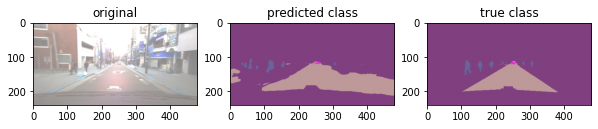

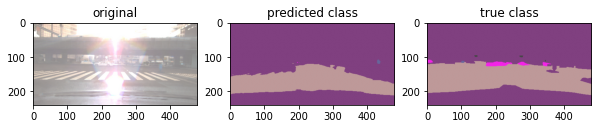

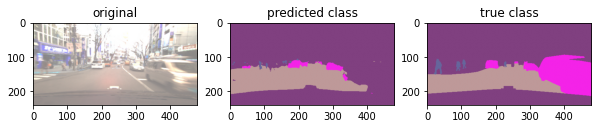

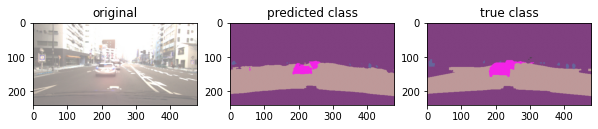

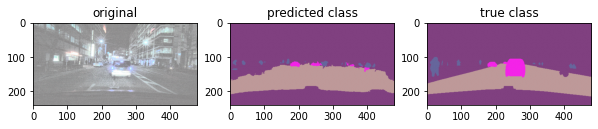

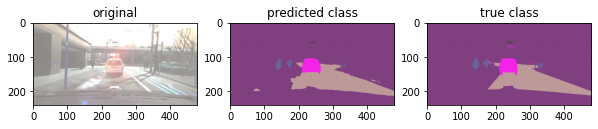

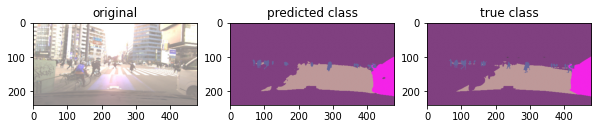

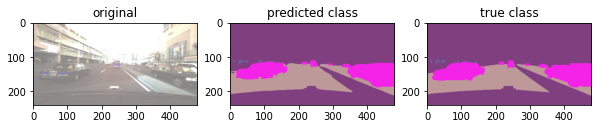

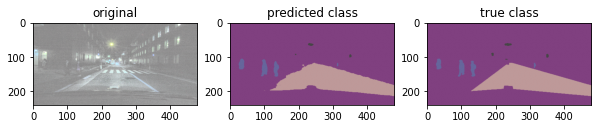

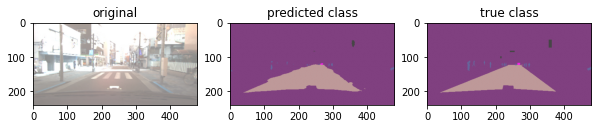

In [48]:
print("\ncomputing IoU over testing data set:")
X_test =X_train
Y_test = Y_train
y_pred1   = model.predict(X_test, batch_size=2)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_test1_i = np.argmax(Y_test, axis=3)
#print(y_test1_i.shape,y_pred1_i.shape)
IoU(y_test1_i, y_pred1_i)

print("\nnow computing IoU over validation data set:")
y_pred2 = model.predict(X_valid, batch_size=2)
y_pred2_i = np.argmax(y_pred2, axis=3)
y_test2_i = np.argmax(Y_valid, axis=3)
#print(y_test2_i.shape,y_pred2_i.shape)
IoU(y_test2_i,y_pred2_i)
visualize_model_performance(X_valid, y_pred2_i, y_test2_i,N_CLASSES)
visualize_model_performance(X_train, y_pred1_i, y_test1_i, N_CLASSES)

In [ ]:

import tensorflow as tf
import sys, time, warnings
import keras as keras
from keras.models import *
from keras.layers import *
#from keras.utils import plot_model #DB
warnings.filterwarnings("ignore")


IMAGE_ORDERING =  "channels_last"



#Function to add 2 convolutional layers with the parameters passed to it
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, activation=True):
    #firt layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', data_format=IMAGE_ORDERING)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', data_format=IMAGE_ORDERING)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)

    return x

# like UNET_v1 but with a Conv2D layer betweeb UpSampling2D aand Concatenate layers
def UNET_v2( nClasses, input_height, input_width, n_filters=16*2, dropout=0.1,
          batchnorm=True, activation=True):

    ## input_height and width must be devisible by 16 because maxpooling with filter size = (2,2) is operated 4 times,
    ## which makes the input_height and width 2^4 = 16 times smaller
    assert input_height%16 == 0
    assert input_width%16 == 0

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    ## Downscaling

    ## Block 1: 64, 64
    c1 = conv2d_block(img_input, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c1 = conv2d_block(c1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1) # 112x112x64

    ## Block 2: 128, 128
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c2 = conv2d_block(c2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2) # 56x56x128

    ## Block 3: 256, 256
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c3 = conv2d_block(c3, n_filters * 4, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3) # 28x28x256

    ## Block 4: 512, 512
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c4 = conv2d_block(c4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4) # 14x14x512

    ## Block5: 1024, 1024
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c5 = conv2d_block(c5, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p5 = Dropout(dropout)(c5) # 14x14x1024
    ## Upscaling

    ## Block6: 512, 512
    up6 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(p5) # 28x28x1024
    u6 = Conv2D(filters=n_filters*8, kernel_size=2, data_format=IMAGE_ORDERING,
                activation="relu", padding="same", kernel_initializer="he_normal")(up6)
    m6 = Concatenate(axis=3)([u6, c4])
    m6 = BatchNormalization()(m6)
    c6 = conv2d_block(m6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    
    ## Block7: 256, 256
    up7 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c6) #56x56x256
    u7 = Conv2D(filters=n_filters*4, kernel_size=2, data_format=IMAGE_ORDERING,
                activation="relu", padding="same", kernel_initializer="he_normal")(up7)
    m7 = Concatenate(axis=3)([u7, c3])
    m7 = BatchNormalization()(m7)
    c7 = conv2d_block(m7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    
    ## Block8: 128, 128
    up8 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c7) # 112x112x128
    u8  = Conv2D(filters=n_filters*2, kernel_size=2, data_format=IMAGE_ORDERING,
                activation="relu", padding="same", kernel_initializer="he_normal")(up8)
    m8  = Concatenate(axis=3)([u8, c2])
    m8 = BatchNormalization()(m8)
    c8 = conv2d_block(m8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    
    ## Block9: 64, 64
    up9 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c8) # 224x224x64
    u9  = Conv2D(filters=n_filters*1, kernel_size=2, data_format=IMAGE_ORDERING,
                activation="relu", padding="same", kernel_initializer="he_normal")(up9)
    m9 = Concatenate(axis=3)([u9, c1])
    m9 = BatchNormalization()(m9)
    c9 = conv2d_block(m9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    
    ## Last layers
    c10 = Conv2D(filters=nClasses, kernel_size=1, data_format=IMAGE_ORDERING)(c9)
    o = (Activation("softmax"))(c10)
    model = Model(inputs=img_input, outputs=o)

    return model


